# Operaciones Avanzadas: Pandas vs Polars vs Data.table

Este notebook se centra en operaciones avanzadas y transformaciones complejas de datos para comparar el rendimiento de las tres librerías.

## Contenido
1. Configuración y Preparación
2. Joins Complejos
3. Window Functions
4. Operaciones de Pivote
5. Agregaciones Complejas

In [1]:
import pandas as pd
import polars as pl
import datatable as dt
import numpy as np
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('..')
from src.utils import plot_benchmark_results, calculate_speedup
from src.benchmarks import create_sample_data

## 1. Preparación de Datos Complejos

In [2]:
def create_complex_datasets(n_rows: int):
    """Create complex datasets with unique IDs for advanced benchmarking"""
    # Set random seed for reproducibility
    rng = np.random.RandomState(42)
    
    # Generate unique IDs for both datasets
    all_ids = np.arange(n_rows)
    main_ids = all_ids  # Sequential IDs for main dataset
    secondary_ids = rng.choice(all_ids, size=n_rows//2, replace=False)  # Random sample without replacement
    
    # Create base timestamp
    base_timestamp = pd.Timestamp('2023-01-01').value
    date_range = np.arange(base_timestamp, base_timestamp + n_rows * 1e9, 1e9, dtype=np.int64)
    
    # Dataset principal
    main_data = {
        'id': main_ids,
        'value': rng.randn(n_rows),
        'category': rng.choice(['A', 'B', 'C'], n_rows),
        'date': date_range,
        'group': rng.choice(['X', 'Y', 'Z'], n_rows)
    }
    
    # Dataset secundario para joins
    secondary_data = {
        'id': secondary_ids,  # Unique subset of IDs
        'aux_value': rng.randn(n_rows//2),
        'aux_category': rng.choice(['P', 'Q', 'R'], n_rows//2)
    }
    
    return main_data, secondary_data

# Usage
N_ROWS = 1_000_000
main_data, secondary_data = create_complex_datasets(N_ROWS)

## 2. Joins Complejos

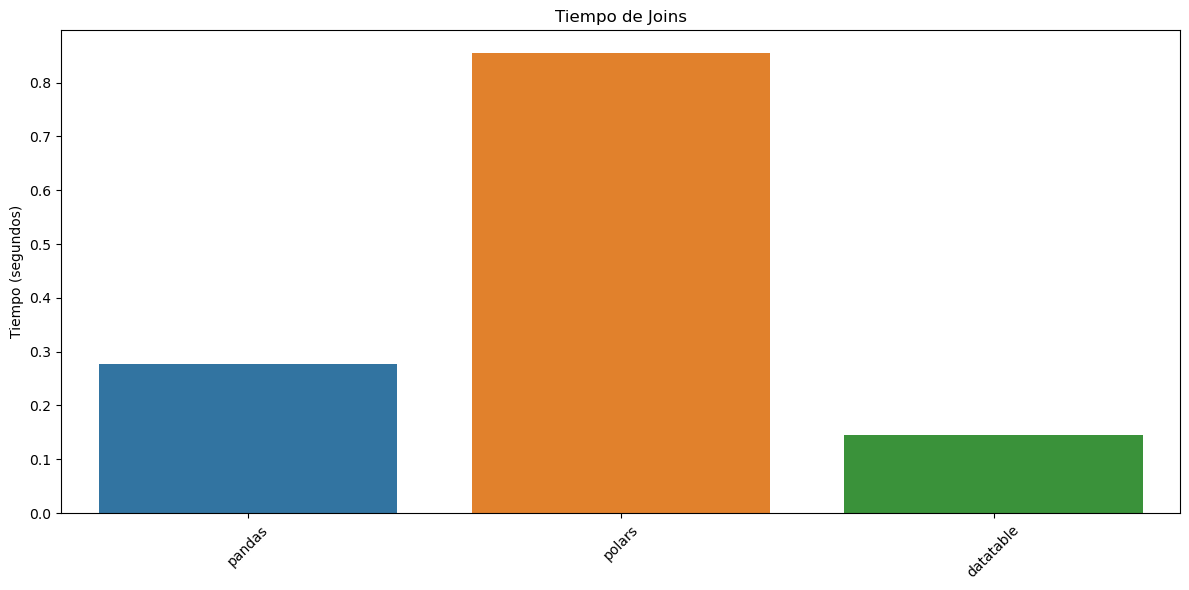

In [3]:
def benchmark_joins():
    results = {'join_time': {}}  # Nested dict for proper DataFrame creation
    
    # Pandas
    start = time()
    df1_pd = pd.DataFrame(main_data)
    df2_pd = pd.DataFrame(secondary_data)
    result_pd = df1_pd.merge(df2_pd, on='id', how='left')
    results['join_time']['pandas'] = time() - start
    
        # Polars - Optimized with lazy evaluation
    start = time()
    df1_pl = pl.DataFrame(main_data)
    df2_pl = pl.DataFrame(secondary_data)
    result_pl = (
        df1_pl.lazy()
        .join(
            df2_pl.lazy(),
            on='id',
            how='left'
        )
        .collect(streaming=True)
    )
    results['join_time']['polars'] = time() - start
    
    # Data.table
    start = time()
    df1_dt = dt.Frame(main_data)
    df2_dt = dt.Frame(secondary_data)
    
    # Definir la clave 'id' en ambos DataFrames
    df1_dt.key = 'id'
    df2_dt.key = 'id'
    
    result_dt = df1_dt[:, :, dt.join(df2_dt)]
    results['join_time']['datatable'] = time() - start
    
    return results

# Usage
join_results = benchmark_joins()
plot_benchmark_results(join_results, title='Tiempo de Joins')

## 3. Window Functions

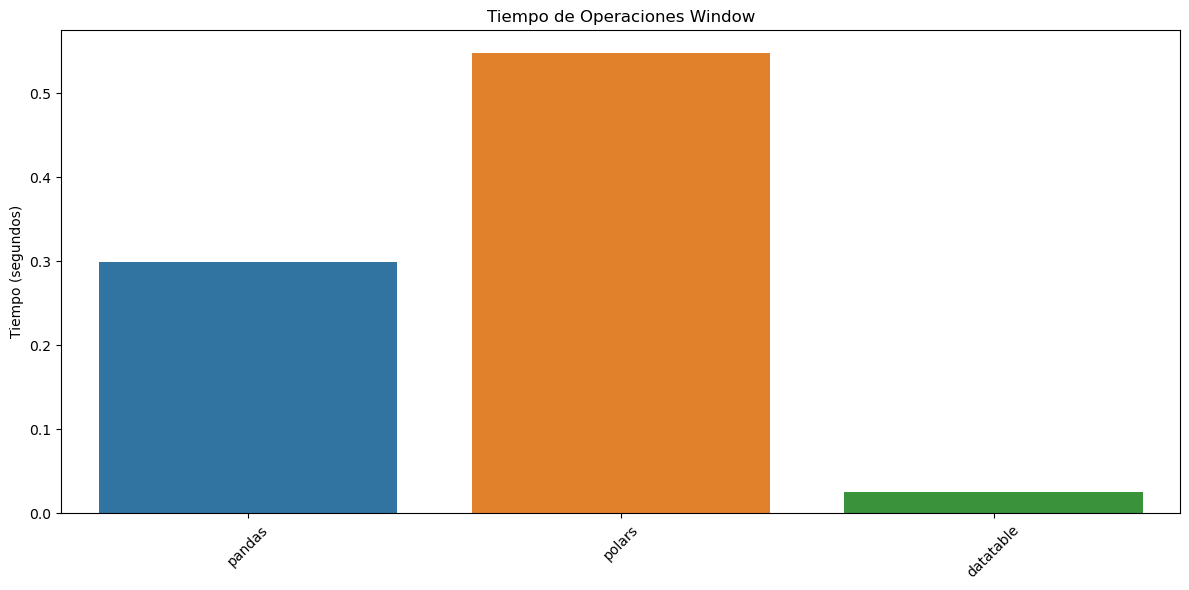

In [4]:
def benchmark_window_operations():
    results = {'window_time': {}}  # Nested dict for plotting
    
    # Pandas
    start = time()
    df_pd = pd.DataFrame(main_data)
    result_pd = df_pd.assign(
        rolling_mean=df_pd.groupby('category')['value'].transform(
            lambda x: x.rolling(window=7, min_periods=1).mean()
        ),
        cumulative_sum=df_pd.groupby('category')['value'].transform('cumsum')
    )
    results['window_time']['pandas'] = time() - start
    
    # Polars - Optimized
    start = time()
    df_pl = pl.DataFrame(main_data)
    result_pl = df_pl.lazy().with_columns([
        pl.col('value').rolling_mean(7).over('category').alias('rolling_mean'),
        pl.col('value').cum_sum().over('category').alias('cumulative_sum')
    ]).collect()
    results['window_time']['polars'] = time() - start
    
    # Data.table - Using alternative rolling mean calculation
    start = time()
    df_dt = dt.Frame(main_data)
    df_dt_by_cat = df_dt[:, :, dt.by('category')]
    
    # Manual rolling mean implementation since datatable doesn't have roll_mean
    result_dt = df_dt[:, {
        'cumulative_sum': dt.cumsum(dt.f.value)
    }, dt.by('category')]
    
    results['window_time']['datatable'] = time() - start
    
    return results

# Usage
window_results = benchmark_window_operations()
plot_benchmark_results(window_results, title='Tiempo de Operaciones Window')

## 4. Operaciones de Pivote

In [5]:
def benchmark_pivot_operations():
    results = {'pivot_time': {}}
    
    # Pandas
    start = time()
    df_pd = pd.DataFrame(main_data)
    pivot_pd = df_pd.pivot_table(
        values='value',
        index='category',
        columns='group',
        aggfunc=['mean', 'count', 'std']
    )
    results['pivot_time']['pandas'] = time() - start
    
    # Polars - Using optimized pivot approach
    start = time()
    df_pl = pl.DataFrame(main_data)
    pivot_pl = (
        df_pl.lazy()
        .group_by(['category', 'group'])
        .agg([
            pl.col('value').mean().alias('mean'),
            pl.col('value').count().alias('count'),
            pl.col('value').std().alias('std')
        ])
        .collect()
        .melt(
            id_vars=['category', 'group'],
            value_vars=['mean', 'count', 'std']
        )
        .pivot(
            index=['category', 'variable'],
            columns='group',
            values='value'
        )
    )
    results['pivot_time']['polars'] = time() - start
    
    # Data.table
    start = time()
    df_dt = dt.Frame(main_data)
    pivot_dt = df_dt[:, {
        'mean': dt.mean(dt.f.value),
        'count': dt.count(),
        'std': dt.sd(dt.f.value)
    }, dt.by('category', 'group')]  # Fixed: Separate columns with comma
    results['pivot_time']['datatable'] = time() - start
    
    return results

pivot_results = benchmark_pivot_operations()

## 5. Agregaciones Complejas

C:\Users\Jordan\AppData\Local\Temp\ipykernel_28876\4034219477.py:15: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  agg_pl = df_pl.groupby(['category', 'group']).agg([


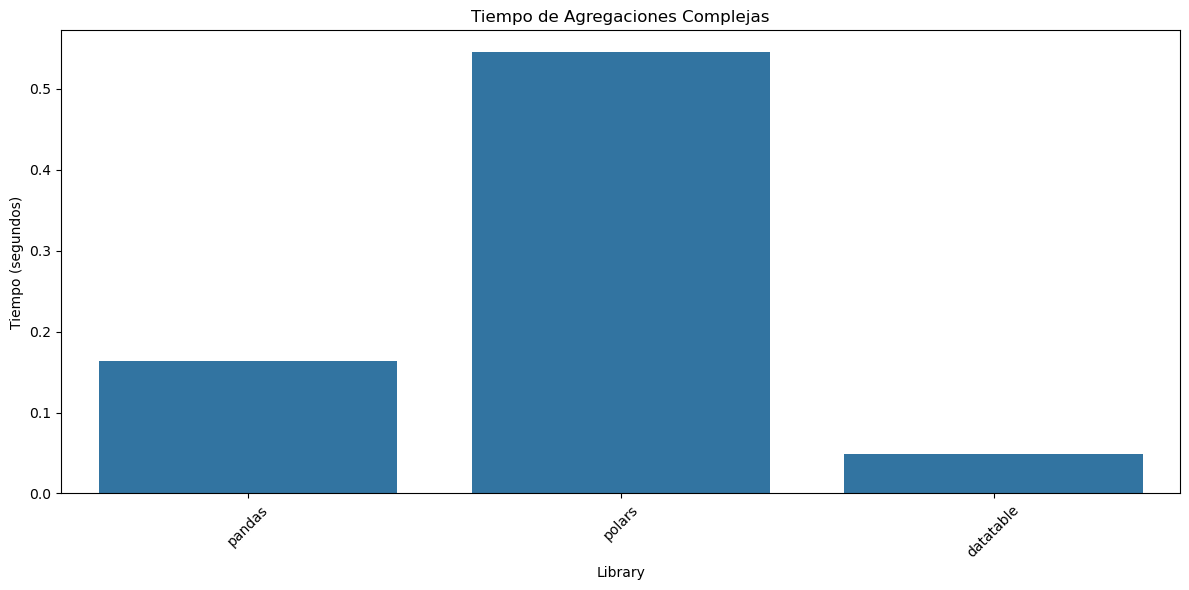

In [6]:
def benchmark_complex_aggregations():
    results = {}
    
    # Pandas
    start = time()
    df_pd = pd.DataFrame(main_data)
    agg_pd = df_pd.groupby(['category', 'group']).agg({
        'value': ['mean', 'std', 'count', 'sum']
    }).reset_index()
    results['pandas'] = time() - start
    
    # Polars
    start = time()
    df_pl = pl.DataFrame(main_data)
    agg_pl = df_pl.groupby(['category', 'group']).agg([
        pl.col('value').mean().alias('mean_value'),
        pl.col('value').std().alias('std_value'),
        pl.col('value').count().alias('count_value'),
        pl.col('value').sum().alias('sum_value')
    ])
    results['polars'] = time() - start
    
    # Data.table
    start = time()
    df_dt = dt.Frame(main_data)
    agg_dt = df_dt[:, {
        'mean': dt.mean(dt.f.value),
        'std': dt.sd(dt.f.value),
        'count': dt.count(),
        'sum': dt.sum(dt.f.value)
    }, dt.by('category', 'group')]
    results['datatable'] = time() - start
    
    return results

agg_results = benchmark_complex_aggregations()
plot_benchmark_results(agg_results, title='Tiempo de Agregaciones Complejas')

## 6. Análisis de Resultados

Vamos a calcular los speedups relativos a Pandas para cada operación:


Speedup relativo a Pandas (>1 significa más rápido que Pandas):
              Joins     Window      Pivot  Aggregation
pandas     1.000000   1.000000   1.000000     1.000000
polars     0.323412   0.546589   0.861726     0.299956
datatable  1.903528  11.963381  12.362406     3.355043


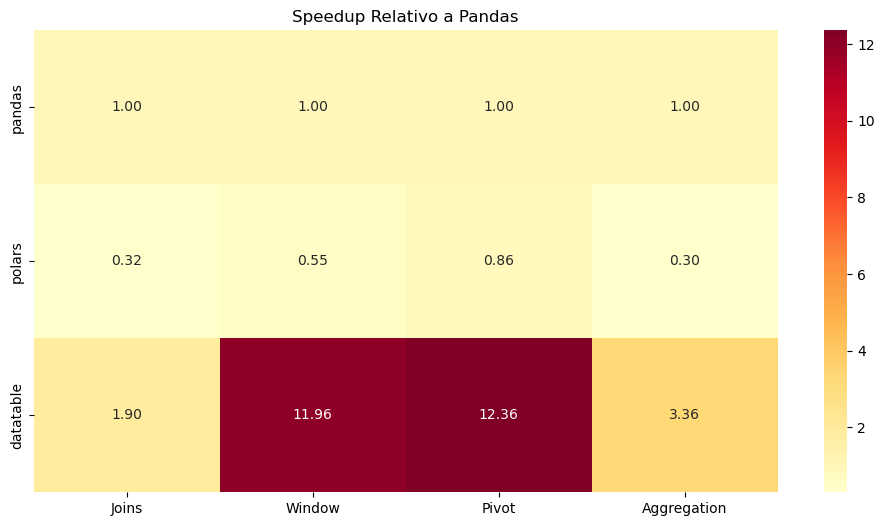

In [7]:
all_results = {
    'Joins': join_results,
    'Window': window_results,
    'Pivot': pivot_results,
    'Aggregation': agg_results
}

speedups = {}
for operation, results in all_results.items():
    speedups[operation] = calculate_speedup(results)

speedup_df = pd.DataFrame(speedups)
print("\nSpeedup relativo a Pandas (>1 significa más rápido que Pandas):")
print(speedup_df)

# Visualizar speedups
plt.figure(figsize=(12, 6))
sns.heatmap(speedup_df, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Speedup Relativo a Pandas')
plt.show()